In [1]:
import cv2
import torch
from torch import optim
from torch.autograd.functional import jacobian
from PIL import Image
import OpenEXR, Imath
import numpy as np
from matplotlib import pyplot as plt
import time

In [2]:
def q_to_c_2d(q, H, W):
    l = 20
    n = q.shape[0]-1
    c = torch.zeros((n,2), device=q.device)
    c[0, 0] = q[0]
    c[0, 1] = q[1]
    for i in range(1, n):
        c[i, 0] = c[i-1, 0] + l*torch.cos(q[i+1])
        c[i, 1] = c[i-1, 1] + l*torch.sin(q[i+1])
#     print(c)
    c_in_img = c.clone()
    c_in_img[:, 0] = H-c[:, 1]
    c_in_img[:, 1] = c[:, 0]
    return c_in_img

def q_to_c_2d_flat(q, H, W):
    return q_to_c_2d(q, H, W).view(-1)

In [3]:
def exr_to_np(path):
    y_resolution = 540
    x_resolution = 810
    pt = Imath.PixelType(Imath.PixelType.FLOAT)
    
    rgb_exr = OpenEXR.InputFile(path)
    rgb_dw = rgb_exr.header()['dataWindow']
    rgb_size = (rgb_dw.max.x - rgb_dw.min.x + 1, rgb_dw.max.y - rgb_dw.min.y + 1)
    r_str = rgb_exr.channel('R', pt)
    g_str = rgb_exr.channel('G', pt)
    b_str = rgb_exr.channel('B', pt)
    rgb_img = np.zeros((y_resolution, x_resolution, 3))
    r_ch = Image.frombytes("F", rgb_size, r_str)
    g_ch = Image.frombytes("F", rgb_size, g_str)
    b_ch = Image.frombytes("F", rgb_size, b_str)
    rgb_img[: ,:, 2] = np.array(r_ch.getdata()).reshape(y_resolution, x_resolution)
    rgb_img[: ,:, 1] = np.array(g_ch.getdata()).reshape(y_resolution, x_resolution)
    rgb_img[: ,:, 0] = np.array(b_ch.getdata()).reshape(y_resolution, x_resolution)
    min_val = rgb_img.min()
    max_val = rgb_img.max() 
    rgb_img = ((rgb_img - min_val)/(max_val - min_val) * 255.0).astype(np.uint8)
    return rgb_img

In [4]:
class tracker:
    def __init__(self, H, W, cuda=False):
        self.H = H
        self.W = W
        self.cuda = cuda
        
    def set_obs(self, mask, rgb_np=None, subsample=False):
        if subsample:
#             N = mask.nonzero().shape[0]
#             n = 100
#             rand_idx = np.random.choice(N, n)
#             sub = torch.zeros_like(mask)
#             sub[mask.nonzero()[rand_idx][:, 0], mask.nonzero()[rand_idx][:, 1]] = True
#             self.mask = sub
#             if self.cuda:
#                 self.mask = sub.cuda()
            import point_cloud_utils as pcu

            # v is a nv by 3 NumPy array of vertices
            # n is a nv by 3 NumPy array of vertex normals
            # n is a nv by 4 NumPy array of vertex colors
            N = mask.nonzero().shape[0]
            print("Before subsample:", N)
            v = np.zeros((N, 3))
            n = np.zeros_like(v)
            c = np.zeros((N, 4))
            v[:, :2] = mask.nonzero()
            n[:, 2] = 1.

            # We'll use a voxel grid with 128 voxels per axis
            num_voxels_per_axis = 128

            # Size of the axis aligned bounding box of the point cloud
            bbox_size = v.max(0) - v.min(0) + np.array([0., 0., 0.1])

            # The size per-axis of a single voxel
            sizeof_voxel = bbox_size / num_voxels_per_axis

            # Downsample a point cloud on a voxel grid so there is at most one point per voxel.
            # Multiple points, normals, and colors within a voxel cell are averaged together.
            v_sampled, n_sampled, c_sampled = pcu.downsample_point_cloud_voxel_grid(sizeof_voxel, v, n, c)
            mask_idx_spl = v_sampled[:, :2]
            mask_spl = torch.zeros_like(mask)
            mask_spl[mask_idx_spl[:, 0], mask_idx_spl[:, 1]] = True
            self.mask = mask_spl
            print("After subsample:", mask_spl.shape[0])
            if self.cuda:
                self.mask = mask_spl.cuda()
        else:
            mask = (~mask).astype(np.uint8)*255
            dist = cv2.distanceTransform(mask, cv2.DIST_L2, 3)
            sobelx = cv2.Sobel(dist,cv2.CV_64F,1,0,ksize=-1)/30.56
            sobely = cv2.Sobel(dist,cv2.CV_64F,0,1,ksize=-1)/30.56
            
            self.mask = torch.Tensor(mask)
            self.dist = torch.Tensor(dist)
            self.dist_x = torch.Tensor(sobelx)
            self.dist_y = torch.Tensor(sobely)
            if self.cuda:
                self.mask = self.mask.cuda()
                self.dist = self.dist.cuda()
                self.dist_x = self.dist_x.cuda()
                self.dist_y = self.dist_y.cuda()
                
        self.rgb_np = rgb_np
        
    def set_init(self, q):
        self.q = q
        if self.cuda:
            self.q = q.cuda()
        
    def dist_fn(self, q):
        sigma = 3
        c = q_to_c_2d(q, self.H, self.W, cuda=self.cuda)
        xy = construct_xy(self.H, self.W, cuda=self.cuda)
        prev_dist = dist_to_line_2d(xy.clone(), c[0], c[1])
        for i in range(c.shape[0]-1):
            dist = torch.minimum(dist_to_line_2d(xy.clone(), c[i], c[i+1]), prev_dist)
            prev_dist = dist
#         dist = torch.exp(-dist * dist/(sigma**2))
        dist = dist[self.mask]
        return dist
        
    def step(self):
        # fwd
        prev_q = self.q.clone()
        changed = False
        step_size = 0.5/self.mask.sum()
        weight_decay = 0.9
        step = 0
        print('---- optimize translation ----')
        while((((prev_q-self.q).norm().item() > 0.5) or not changed) and step < 10):
            prev_q = self.q.clone()
            q_grad = self.q.clone().detach().requires_grad_(True)
            loss = loss_fn(q_grad, H, W, mask)
            print('loss:', loss)
            loss.backward()
            grad = q_grad.grad.clone().detach()
            grad[2:] = 0
            self.q = q_grad.clone().detach()
            self.q -= grad * step_size
            step_size *= weight_decay
            print(self.q)
            print(grad)
            changed = True
            step += 1

        changed = False
        step_size = 10**-5
        weight_decay = 0.9
        step = 0
        print('---- optimize rotation ----')
        while((((prev_q-self.q).norm().item() > 0.5) or not changed) and step < 10):
            prev_q = self.q.clone()
            q_grad = self.q.clone().detach().requires_grad_(True)
            loss = loss_fn(q_grad, H, W, mask)
            loss.backward()
            grad = q_grad.grad.clone().detach()
            self.q = q_grad.clone().detach()
            self.q -= grad * step_size
            step_size *= weight_decay
            print(self.q)
            print(grad)
            changed = True
            step += 1
    
    def gauss_step(self):
#         print('---- optimize translation ----')
#         curr_norm = float('Inf')
#         while True:
#             prev_norm = curr_norm
#             J=jacobian(self.dist_fn, self.q)
#             dist = self.dist_fn(self.q)
#             curr_norm = dist.norm()
#             print(self.q)
#             print(dist.norm())
#             if curr_norm >= prev_norm:
#                 self.q = prev_q
#                 break
#             prev_q = self.q.clone()
#             try:
#                 delta_q = torch.mm(torch.mm(torch.mm(J.t(), J).inverse(), J.t()), dist.unsqueeze(1)).squeeze()
#                 delta_q[2:] = 0
#             except:
#                 delta_q = torch.mm(torch.mm(torch.mm(J.t(), J).pinverse(), J.t()), dist.unsqueeze(1)).squeeze()
#                 delta_q[2:] = 0
#             self.q -= delta_q
        
        print('---- optimize rotation ----')
        curr_norm = float('Inf')
        while True:
            prev_norm = curr_norm
            J=jacobian(self.dist_fn, self.q)
            dist = self.dist_fn(self.q)
            curr_norm = dist.norm()
            print(self.q)
            print(dist.norm())
            if curr_norm >= prev_norm:
                self.q = prev_q
                break
            prev_q = self.q.clone()
            try:
                delta_q = torch.mm(torch.mm(torch.mm(J.t(), J).inverse(), J.t()), dist.unsqueeze(1)).squeeze()
            except:
                delta_q = torch.mm(torch.mm(torch.mm(J.t(), J).pinverse(), J.t()), dist.unsqueeze(1)).squeeze()
            self.q -= delta_q
    
    def lm_step(self):
        pass
    
    def q_to_c_2d(self, q):
        l = 20
        n = q.shape[0]-1
        c = torch.zeros((n,2), device=q.device)
        c[0, 0] = q[0]
        c[0, 1] = q[1]
        for i in range(1, n):
            c[i, 0] = c[i-1, 0] + l*torch.cos(q[i+1])
            c[i, 1] = c[i-1, 1] + l*torch.sin(q[i+1])
    #     print(c)
        c_in_img = c.clone()
        c_in_img[:, 0] = self.H-c[:, 1]-1
        c_in_img[:, 1] = c[:, 0]
        return c_in_img

    def q_to_c_2d_flat(self, q):
        return self.q_to_c_2d(q).view(-1)
    
    def gauss_obj_step(self):
        curr_norm = float('Inf')
        while True:
            prev_norm = curr_norm
            nabla_q=jacobian(self.q_to_c_2d_flat, self.q) # (2*Nc, Nq)
            c = self.q_to_c_2d(self.q) # (Nc, 2)
            nabla_D = torch.zeros_like(c, device=c.device) # (Nc, 2)
            c = c.long()
            nabla_D[:, 1] = self.dist_x[c[:, 0], c[:, 1]]
            nabla_D[:, 0] = self.dist_y[c[:, 0], c[:, 1]]
            nabla_D = nabla_D.view(-1) # (2*Nc, )
            nabla_D = torch.diag(nabla_D) # (2*Nc, 2*Nc)
            J = torch.mm(nabla_D, nabla_q) # (2*Nc, Nq)
            J = J[0::2]+J[1::2] # (Nc, Nq)
            
            # calculate loss
            dist = self.dist[c[:, 0], c[:, 1]]
            curr_norm = torch.square(dist).sum()
            
            print("q:")
            print(self.q)
            print("loss:")
            print(curr_norm)
            print("dist:")
            print(dist)
            print("nabla_q:")
            print(nabla_q)
            print("nabla_D:")
            print(nabla_D)
            print("J:")
            print(J)
            print("Gradient:")
            print(torch.mm(J.t(), dist.unsqueeze(1)))
            
            if curr_norm >= prev_norm:
                self.q = prev_q
                break
            prev_q = self.q.clone()
            try:
                delta_q = torch.mm(torch.mm(torch.mm(J.t(), J).inverse(), J.t()), dist.unsqueeze(1)).squeeze()
            except:
                delta_q = torch.mm(torch.mm(torch.mm(J.t(), J).pinverse(), J.t()), dist.unsqueeze(1)).squeeze()
            self.q -= delta_q
            
            
    def vis(self, save_dir=None, idx=0):
        if self.rgb_np is not None:
            vis_img = self.rgb_np.copy()
        else:
            vis_img = np.zeros((self.H, self.W))

        radius = 3
        color = (255, 0, 0)
        thickness = 2

        c = q_to_c_2d(self.q, self.H, self.W)
        for i in range(c.shape[0]):
            vis_img = cv2.circle(vis_img, (int(c[i][1]), int(c[i][0])), radius, color, thickness)
        plt.imshow(vis_img)
        if save_dir is not None:
            import pathlib
            pathlib.Path(save_dir).mkdir(parents=True, exist_ok=True)
            plt.savefig(save_dir+"frame_"+'{0:03d}'.format(idx)+".png")
        plt.show()

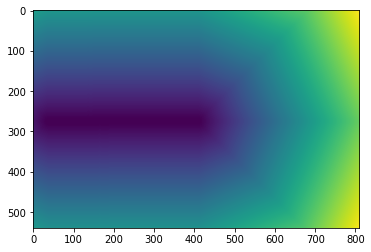

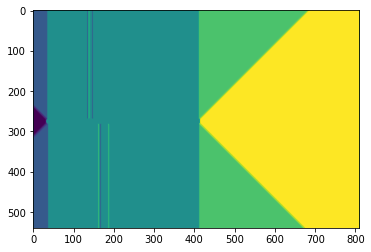

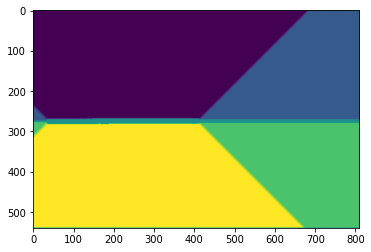

In [5]:
# distance transform
data_path = "/home/yixuan/dart_deformable/data/rope_simple/"
i = 0
rgb_np = exr_to_np(data_path+"rgb_"+'{0:03d}'.format(i)+".exr")
# _, mask = cv2.threshold(rgb_np[:, :, 2], 100, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
mask = rgb_np[:, :, 2] > 100
mask = (~mask).astype(np.uint8)*255
# print(mask.shape)
# print(mask.dtype)
dist = cv2.distanceTransform(mask, cv2.DIST_L2, 3)
plt.imshow(dist)
plt.show()
sobelx = cv2.Sobel(dist,cv2.CV_64F,1,0,ksize=-1)
sobely = cv2.Sobel(dist,cv2.CV_64F,0,1,ksize=-1)
plt.imshow(sobelx)
plt.show()
plt.imshow(sobely)
plt.show()

q:
tensor([220., 339.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       device='cuda:0')
loss:
tensor(403.1166, device='cuda:0')
dist:
tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.9550, 20.0550], device='cuda:0')
nabla_q:
tensor([[  0.,  -1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,  -1., -20.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,  -1., -20., -20.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,  -1., -20., -20., -20.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,  -1., -20., -20., -20., -20.,   0

q:
tensor([ 2.1809e+02,  3.3900e+02, -4.7750e-02, -2.3385e-07,  1.3238e-07,
         1.0222e-07,  4.1324e-08, -2.5051e-07,  2.7303e-07, -2.9724e-07,
         9.5956e+00,  2.8065e-02], device='cuda:0')
loss:
tensor(0., device='cuda:0')
dist:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
nabla_q:
tensor([[ 0.0000e+00, -1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -1.0000e+00, -1.9977e+01,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 1.0000e+00,  0.0000e+00,  9.5463e-01,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.000

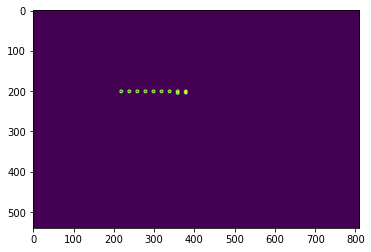

In [10]:
# gauss-newton method sanity check
H = 540
W = 810
simple_tracker = tracker(H, W,cuda=True)
q = torch.zeros((12,))
q[0] = 220
q[1] = 339
simple_tracker.set_init(q)
mask = np.zeros((H, W), dtype=bool)
mask[200:205, 200:400] = True
simple_tracker.set_obs(mask)
simple_tracker.gauss_obj_step()
simple_tracker.vis()

In [10]:
# simple rope tracking with subsample
H = 540
W = 810
simple_tracker_sub = tracker(H, W, cuda=True)
q = torch.zeros((20,))
q[0] = 40
simple_tracker_sub.set_init(q)
data_path = "/home/yixuan/dart_deformable/data/rope_simple/"
for i in range(251):
    rgb_np = exr_to_np(data_path+"rgb_"+'{0:03d}'.format(i)+".exr")
    mask = rgb_np[:, :, 2] > 100
    simple_tracker_sub.set_obs(mask, rgb_np)
    start = time.time()
    simple_tracker_sub.gauss_obj_step()
    print("one iteration takes:", time.time()-start)
    simple_tracker_sub.vis(save_dir="/home/yixuan/dart_deformable/result/rope_simple_obj_loss/", idx=i)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.